In [1]:
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 300

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()     # calls the constructor of nn.Module to initialize it properly
        self.linear1 = nn.Linear(784, 512)  # each mnist data image has 28X28 (784) pixels 
        self.linear2 = nn.Linear(512, latent_dims)
        
    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)
        
    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)
        
    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [6]:
def train(autoencoder, data, epochs=20):
    optimizer = torch.optim.Adam(autoencoder.parameters())
    for epoch in range(epochs):
        for x, y in data:
            x = x.to(device)                    # data to selected device, usually gpu
            optimizer.zero_grad()               # reeset gradients to prevent gradient accumulations
            x_hat = autoencoder(x)              # outputs
            loss = ((x - x_hat) ** 2).sum()     # calculate loss
            loss.backward()                     # compute gradient
            optimizer.step()                    # update weights
    return autoencoder                          # return value: trained autoencoder

In [7]:
latent_dims = 2
autoencoder = Autoencoder(latent_dims).to(device)   # initialize model

# load MNIST dataset
data = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data',
                                transform=torchvision.transforms.ToTensor(),
                                download=True),
    batch_size=128,
    shuffle=True
)

# train the model
autoencoder = train(autoencoder, data)

In [45]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10', s=10)
        if i > num_batches:
            plt.colorbar()
            break

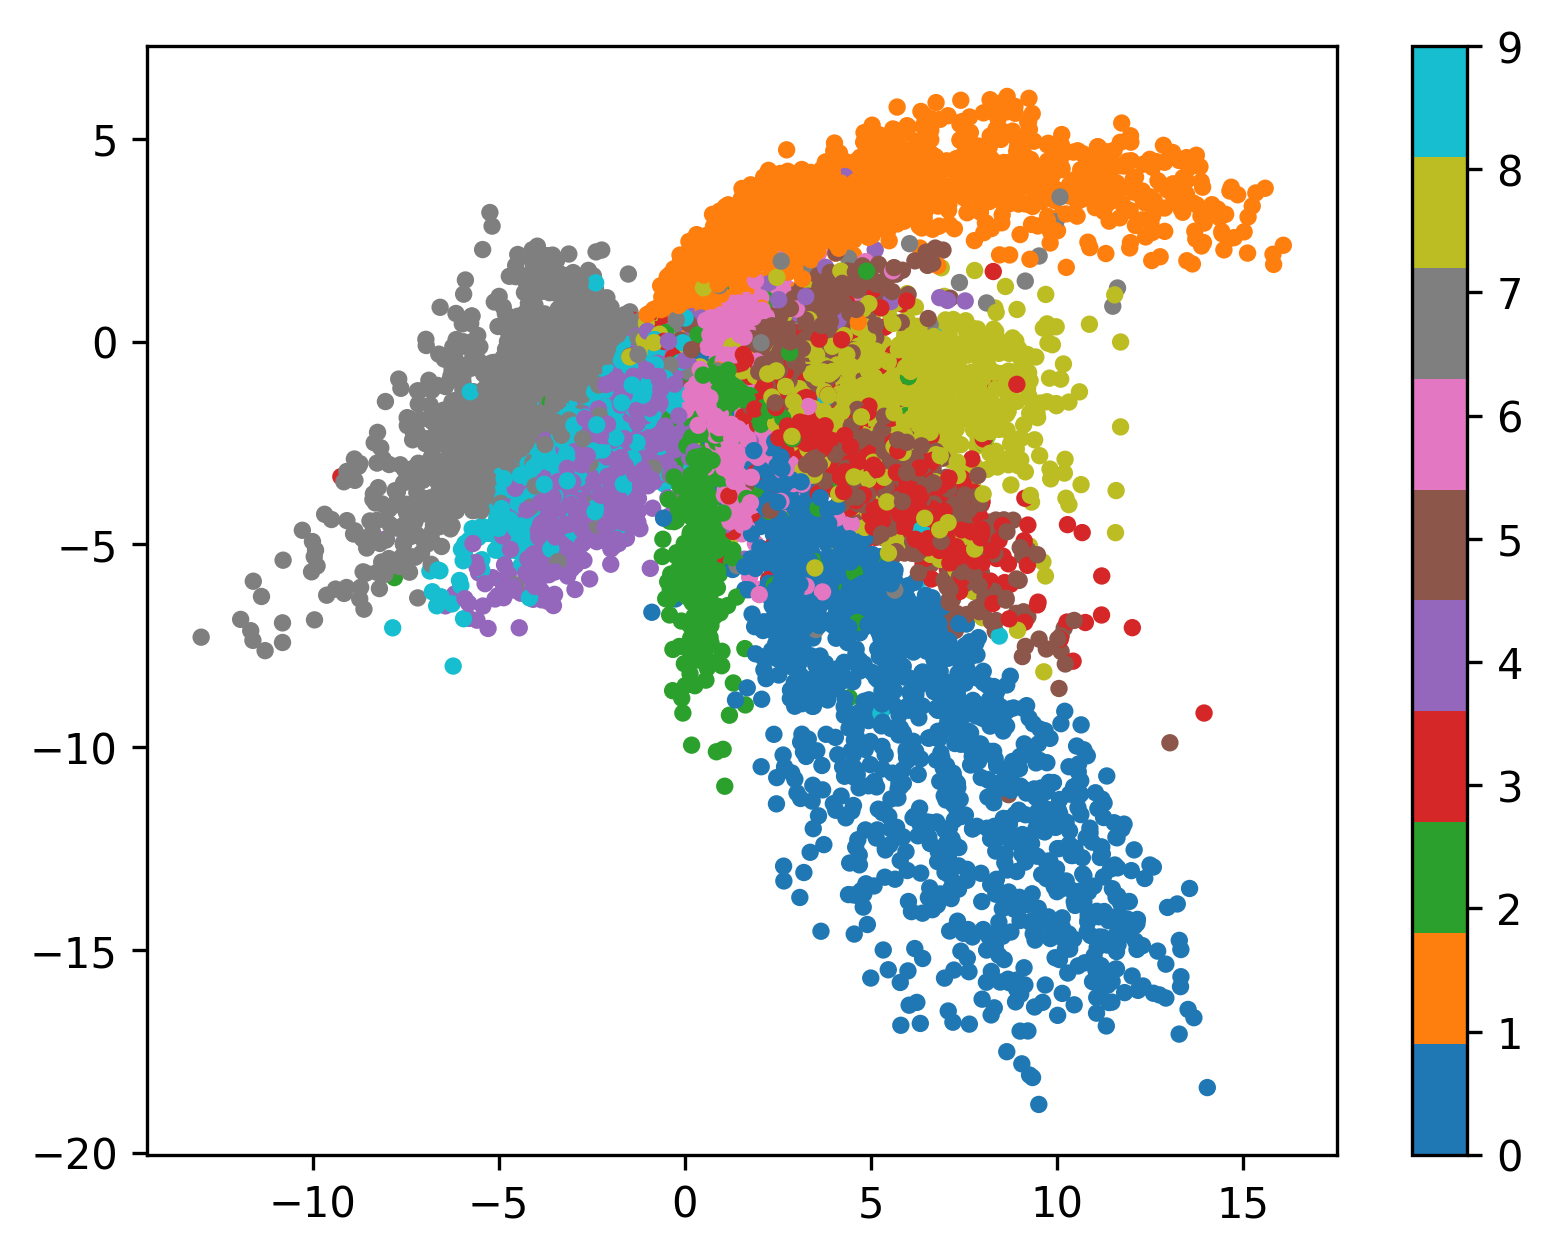

In [46]:
plot_latent(autoencoder, data)

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])